# Introduction

  This python notebook covers the procedure for cleaning and analyzing the dataset containing information on the collisions in Montgomery county. It also highlights the steps taken to answer the created research questions. Firstly, the study will use hypothesis testing to establish a connection between the damage caused by the collision and the hit and runs that follow the collision. After that, various machine learning models will be built to predict hit and run outcomes. The best performing classifier will give insight into which features have most influence over the likelihood of a driver commiting a hit and run.

In [3]:
# Import Libraries
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import warnings
import collections

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Import Dataset
df_raw = pd.read_csv('Crash_Reporting_-_Incidents_Data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# A Quick Glance at the Data

In [5]:
# previe of dataset
df_raw.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Hit/Run,Route Type,Mile Point,Mile Point Direction,Lane Direction,Lane Number,Lane Type,Number of Lanes,Direction,Distance,Distance Unit,Road Grade,NonTraffic,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,At Fault,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Non-Motorist Substance Abuse,First Harmful Event,Second Harmful Event,Fixed Oject Struck,Junction,Intersection Type,Intersection Area,Road Alignment,Road Condition,Road Division,Latitude,Longitude,Location
0,MCP3048005T,190046316,Montgomery County Police,Property Damage Crash,09/27/2019 09:38:00 AM,No,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,"IN FRONT OF 6630 EAMES WAY BETHESDA, MD.",NaN,NaN,DRIVER,SINGLE VEHICLE,CLEAR,NaN,DAYLIGHT,NaN,NaN,NaN,OTHER,NaN,BUILDING,NaN,NaN,NaN,NaN,NaN,NaN,39.026700,-77.136785,"(39.0267, -77.136785)"
1,EJ78460055,200017938,Gaithersburg Police Depar,Property Damage Crash,05/02/2020 02:16:00 PM,Yes,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,949 CLOPPER RD PARKING LOT,NaN,NaN,DRIVER,STRAIGHT MOVEMENT ANGLE,CLEAR,NaN,DAYLIGHT,NO CONTROLS,UNKNOWN,NaN,PARKED VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.147956,-77.229616,"(39.14795617, -77.2296164)"
2,MCP3245000H,200036179,Montgomery County Police,Injury Crash,09/15/2020 03:33:00 PM,No,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,PARKING LOT @ 9827 BROOKRIDGE CT,NaN,NaN,DRIVER,STRAIGHT MOVEMENT ANGLE,CLEAR,NaN,DAYLIGHT,NO CONTROLS,NaN,NaN,OTHER VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.188862,-77.202455,"(39.18886167, -77.202455)"
3,HA23890011,20002466,Maryland-National Capital,Property Damage Crash,10/14/2020 08:40:00 AM,No,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,GRAVEL PARKING LOT AT POPE FARM NURSERY,NaN,NaN,UNKNOWN,NaN,NaN,NaN,DAYLIGHT,NaN,NaN,NaN,UNITS SEPARATED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.158697,-77.146791,"(39.15869731, -77.14679055)"
4,MCP3090003Z,200010527,Montgomery County Police,Property Damage Crash,03/03/2020 09:19:00 AM,No,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,PARKING LOT OF 16705 CRABBS BRANCH WAY,NaN,NaN,DRIVER,SINGLE VEHICLE,CLOUDY,NaN,DAYLIGHT,NaN,NaN,NaN,OTHER OBJECT,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,39.129216,-77.167342,"(39.1292155, -77.16734233)"


In [6]:
# dimensions of dataset
print('Dimensions of raw dataset: {} rows and {} columns'.format(df_raw.shape[0], df_raw.shape[1]))

Dimensions of raw dataset: 71366 rows and 44 columns


## Features

In [7]:
# observing the non-null count and data type of each feature
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71366 entries, 0 to 71365
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Report Number                 71366 non-null  object 
 1   Local Case Number             71366 non-null  object 
 2   Agency Name                   71366 non-null  object 
 3   ACRS Report Type              71366 non-null  object 
 4   Crash Date/Time               71366 non-null  object 
 5   Hit/Run                       71364 non-null  object 
 6   Route Type                    61868 non-null  object 
 7   Mile Point                    62276 non-null  float64
 8   Mile Point Direction          61884 non-null  object 
 9   Lane Direction                62287 non-null  object 
 10  Lane Number                   71366 non-null  int64  
 11  Lane Type                     6925 non-null   object 
 12  Number of Lanes               71366 non-null  int64  
 13  D

It is clear that the dataset is relatively large with 71366 rows and 44 columns. However, due to the large number of null values, some of the features will have to be removed entirely. The remaining missing values will simply be replaced.

# Data Cleaning For Inferential and Descriptive Statistics

Before attempting to remove all the null values, it is important to address all the observations with features being assigned the value 'UNKNOWN'. This value is equivalent to a null value in most cases and is therefore converted to a null value prior to any removal of features or samples. 


In [8]:
# creating a copy of the raw dataset for preprocessing
df = df_raw.copy(deep=True)

In [9]:
# create a function that replaces the string 'Unknown' with NaN
def replace_unknown(value):
    if value == 'Unknown' or value == 'UNKNOWN':
      return float('NaN')
    else:
      return value
# apply the replace_unknown function on all the columns in the dataset. 
for col in df.columns:
  df[col] = df[col].apply(lambda x: replace_unknown(x))

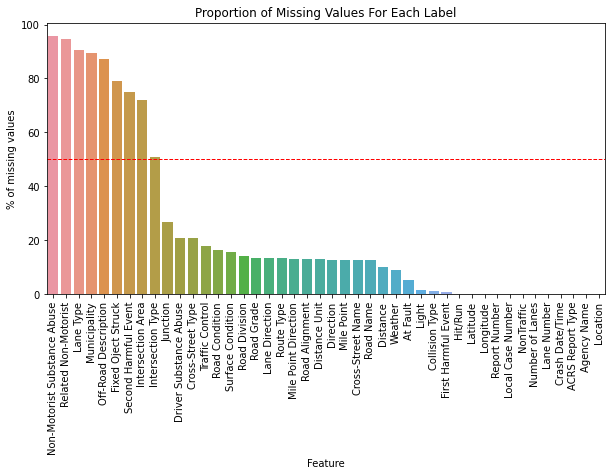

In [10]:
# find the % of missing values of each feature
missing_proportion = pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
missing_proportion = missing_proportion.sort_values(by=missing_proportion.columns[0], ascending=False)

# plot the % of missing values of each feature
plt.figure(figsize=(10,5))
sns.barplot(missing_proportion.index,missing_proportion.iloc[:,0])
plt.ylabel('% of missing values')
plt.xlabel('Feature')
plt.title('Proportion of Missing Values For Each Label')
plt.xticks(rotation=90)
plt.axhline(y=50,linewidth=1, color='red', linestyle='--')
plt.show()

Next, features with too high of a proportion of null values should be ommited as they do not contribute to the study. For this scenario, any feature with missing values in more than 50% of the samples will be removed from the dataset altogether. As shown by the bar chart above, 9 features meet this standard. 

## Step 1: Remove Unwanted Features

All unwanted features will be removed from the dataset. This includes the aforementioned features with too many missing values as well as features that do not relay any valuable information or do not have any relevance to the study of the hit and run cases in Montgomery County. 

In [11]:
# find features with more than 50% missing values
unwanted_features = list(missing_proportion[missing_proportion[missing_proportion.columns[0]]>50].index)
# find features that stored irrelevant or insignifant data
unwanted_features.extend(['Report Number', 'Local Case Number', 'Agency Name', 'Mile Point',
       'Mile Point Direction', 'Lane Direction', 'Lane Number', 'Distance', 'Distance Unit', 'Road Name'
       ,'Cross-Street Type','Cross-Street Name', 'At Fault', 'Off-Road Description',  'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 
       'Route Type','Road Condition', 'Latitude', 'Longitude', 'Location'])
unwanted_features = list(set(unwanted_features))

In [12]:
# drop all unwanted features
df = df.drop(unwanted_features, axis=1)
print('Dimensions of dataset: {} rows and {} columns'.format(df.shape[0], df.shape[1]))

Dimensions of dataset: 71366 rows and 16 columns


## Step 2: Remove/Replace Missing Values

Next, the missing values in the remaining features will be dealt with. For the sake of preserving data, the missing values of each feature is replaced by the mode of that feature. 

In [13]:
# find the number of null values for each feature
df.isnull().sum()

ACRS Report Type           0
Crash Date/Time            0
Hit/Run                    2
Number of Lanes            0
Direction               9120
Road Grade              9660
NonTraffic                 0
Collision Type           884
Weather                 6424
Surface Condition      11164
Light                   1099
Traffic Control        12907
First Harmful Event      549
Junction               19019
Road Alignment          9477
Road Division          10063
dtype: int64

In [14]:
# Replace every feature except for 'Hit/Run' with the mode value
for col in df.columns:
  if col != 'Hit/Run':
    df[col] = df[col].fillna(df[col].mode()[0])

## Step 3: Dealing With Features With Too Many Categories

Features with too many categories can be detrimental to the data modeling procedure since the less popular categories will be deemed to be negligible. For that reason, categories that make up less than 5% of the total observations will be replaced by the category named 'OTHER'. This only applies to features that have more than 3 categories. 

Note: This step does not apply to the 'Crash Date/Time' column. This feature will be handled seperately.

In [15]:
changing_classes = pd.DataFrame()
# finding number of categories in each feature
changing_classes['Feature'] = df.columns
changing_classes['Number of Categories Before Immutation'] = [len(df[feature].value_counts()) for feature in df.columns]

# finding the features that have more than 3 categories
too_many_classes = list(changing_classes[changing_classes['Number of Categories Before Immutation']>3]['Feature'])


In [16]:
# replacing categories that make up less than 5% of the observations with 'OTHER'
for feature in df.columns:
  if feature in too_many_classes and feature != 'Crash Date/Time':
    count = df[feature].value_counts()
    count_percent = (count/len(df))*100
    keep_classes = [i for i, val in enumerate(count_percent) if val >= 5]
    good_classes = list(count[keep_classes].index)
    df[feature] = df[feature].apply(lambda x: x if x in good_classes else 'OTHER')

In [17]:
# showing the change in the number of categories for each feature after immutation
changing_classes['Number of Categories After Immutation'] = [len(df[feature].value_counts()) for feature in df.columns]
changing_classes

,Feature,Number of Categories Before Immutation,Number of Categories After Immutation
0,ACRS Report Type,3,3
1,Crash Date/Time,69610,69610
2,Hit/Run,2,2
3,Number of Lanes,15,6
4,Direction,4,4
5,Road Grade,7,4
6,NonTraffic,2,2
7,Collision Type,17,6
8,Weather,11,4
9,Surface Condition,10,3


In [18]:
# Remove rows where the 'Hit/Run' feature is assigned 'OTHER'
df = df[df['Hit/Run'] != 'OTHER']
df = df[df['Number of Lanes'] != 'OTHER']

## Deal with datetime variables

In [19]:
# Convert 'Crash Date/Time' feature to a datetime variable and store the year, month, day, and hour into separate columns
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])
df['Year'] = df['Crash Date/Time'].dt.year
df['Month'] = df['Crash Date/Time'].dt.month
df['Day'] = df['Crash Date/Time'].dt.day
df['Hour'] = df['Crash Date/Time'].dt.hour

## Save the dataset

After completing the data cleaning procedure, a copy of the dataset is made. This copy will later be exported in order to present descriptive statistics using Tableau. 

In [20]:
# save the dataframe in a different copy 
df_clean = df.copy(deep=True)
df_clean.dropna(inplace=True)

# Inferrential Statistics

It would be ideal to identify the factors that weigh most influence over a driver's decision or ability to commit a hit and run. Out of all the information recorded by the police department, the ACRS report type (the damage from the crash) seems to be the most insightful. It is reasonable for drivers to make their decision to hit and run based on the outcome of their crash. For example, a driver could cause a horrific collision and then chose to leave the scene due to fear or panic. This portion of the study will find evidence of dependency between the damage done by a collision and the corresponding hit and run outcome using the chi-square test for independence. 



**Research Question: Does the outcome of a crash affect a driver's subsequent decision to perform a hit and run?**


Hypothesis test: Chi-Square test for independence

Null Hypothesis: The damage caused by the crash does not affect a driver's decision to hit and run

Alternative Hypothesis: The damage caused by the crash does affect a driver's decision to hit and run

In [21]:
chi_sq_table = pd.crosstab(df['ACRS Report Type'], df['Hit/Run'])
chi_sq_table

Hit/Run,No,Yes
ACRS Report Type,,
Fatal Crash,177,10
Injury Crash,22604,1565
Property Damage Crash,34168,10619


In [22]:
# compute the test statistic and p-value 
chi_stat, p_val, degree_freedom, exp = chi2_contingency(chi_sq_table)

# reject the null hypothesis if the p-value is below 0.05
if p_val < 0.05:
  print('Test statistic: ',chi_stat)
  print('P-value: ',p_val)
  print("Reject the null hypothesis. The damage caused by the crash does affect a driver's decision to hit and run.")
# do not reject the null hypothesis if the p-value is above 0.05
else:
  print('Test statistic: ',chi_stat)
  print('P-value: ',p_val)
  print("Do not reject the null hypothesis. There is not sufficient evidence to prove that the damage caused by the crash affects a driver's decision to hit and run.")

Test statistic:  3229.556056934531
P-value:  0.0
Reject the null hypothesis. The damage caused by the crash does affect a driver's decision to hit and run.


Given the negligible p-value from the chi-square test, there is sufficient evidence to prove that the type of crash does affect a driver's decision to hit and run. The table above suggests that drivers are most likely to hit and run when their crash results in property damage. On the other hand, they are least likely to hit and run when their crash leads to a fatality. 

# Predictive Modeling

A robust model that can predict hit and run outcomes can provide much more insight into the features that impact hit and run cases. Therefore, a predictive model that incorporates machine learning algorithms will be used to determine the features that have most influence over hit and run outcomes.

In many cases, law enforcers and policy makers scrutinize the drivers when attempting to address hit and run cases. After all, such incidents occur due to the drivers' negligence or lapse of judgement. However, this portion of the study will explore this subject from a different angle. Could the infrastructure of roads play a role in the hit and run cases in Montgomery county? For example, if all main roads had sufficient lighting, drivers are much less likely to accidently crash into property or pedestrians. If this is corroborated by predictive models, investments could be made to reduce such incidents, thereby removing the incentive to commit a hit and run.


**Research question: Would improving road conditions impact the likelihood of hit and run cases?**

Hypothesis: Improving road conditions will play a significant role in the decreasing the likelihood of hit and run cases.

 




## Understanding the Target Label

The predictive models will use the 'Hit/Run' feature as the target label. As shown in the pie chart below, the hit and run cases only make up 17.6% of all the observations. This data imbalance leaves the predictive models prone to overfitting due to frequency bias. Measures will be taken in order to account for this issue. 

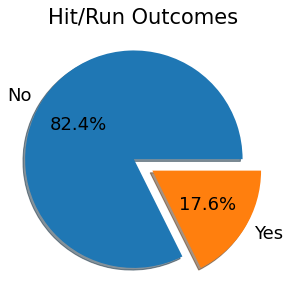

In [23]:
# plotting the proportion of cases with and without hit and runs
plt.figure(figsize=(5,5))
explode = [0.1,0.1]
labels = df['Hit/Run'].value_counts().index
plt.pie(df['Hit/Run'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, textprops={'fontsize':18})
plt.title('Hit/Run Outcomes', fontsize=21)
plt.show()

## Preprocessing for predictive modeling

### Encoding Categorical Variables

Prior to feeding the data to a machine learning classifier, the categorical variables have to be converted to numbers. So, the 'Hit/Run' feature (the target label) is encoded with the label encoder, while the remaining categorical features are encoded with one-hot-encoding.

In [24]:
# Convert 'Hit/Run' column values to string
df['Hit/Run'] = df['Hit/Run'].apply(lambda x: str(x))

# remove 'Crash Date/Time' feature as it is redundant
df = df.drop('Crash Date/Time', axis=1)

In [25]:
# Use label encoder to encode the target label
le = LabelEncoder()
df['Hit/Run'] = le.fit_transform(df['Hit/Run'])

# perform one hot encoding for nominal features
df = pd.get_dummies(df)

In [26]:
# preview of the dataset after encoding
df.head()

,Hit/Run,Year,Month,Day,Hour,ACRS Report Type_Fatal Crash,ACRS Report Type_Injury Crash,ACRS Report Type_Property Damage Crash,Number of Lanes_0,Number of Lanes_1,Number of Lanes_2,Number of Lanes_3,Number of Lanes_4,Direction_East,Direction_North,Direction_South,Direction_West,Road Grade_GRADE DOWNHILL,Road Grade_HILL UPHILL,Road Grade_LEVEL,Road Grade_OTHER,NonTraffic_No,NonTraffic_Yes,Collision Type_HEAD ON LEFT TURN,Collision Type_OTHER,Collision Type_SAME DIR REAR END,Collision Type_SAME DIRECTION SIDESWIPE,Collision Type_SINGLE VEHICLE,Collision Type_STRAIGHT MOVEMENT ANGLE,Weather_CLEAR,Weather_CLOUDY,Weather_OTHER,Weather_RAINING,Surface Condition_DRY,Surface Condition_OTHER,Surface Condition_WET,Light_DARK LIGHTS ON,Light_DAYLIGHT,Light_OTHER,Traffic Control_NO CONTROLS,Traffic Control_OTHER,Traffic Control_STOP SIGN,Traffic Control_TRAFFIC SIGNAL,First Harmful Event_FIXED OBJECT,First Harmful Event_OTHER,First Harmful Event_OTHER VEHICLE,First Harmful Event_PARKED VEHICLE,Junction_INTERSECTION,Junction_INTERSECTION RELATED,Junction_NON INTERSECTION,Junction_OTHER,Road Alignment_CURVE LEFT,Road Alignment_CURVE RIGHT,Road Alignment_OTHER,Road Alignment_STRAIGHT,Road Division_OTHER,"Road Division_TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER","Road Division_TWO-WAY, DIVIDED, UNPROTECTED PAINTED MIN 4 FEET","Road Division_TWO-WAY, NOT DIVIDED"
0,0,2019,9,27,9,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,1,2020,5,2,14,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
2,0,2020,9,15,15,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
3,0,2020,10,14,8,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0
4,0,2020,3,3,9,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0


In [27]:
# ensuring there are only two categoories in 'Hit/Run' feature
df = df[df['Hit/Run']!=2]

### Splitting the data into training and testing sets

In this step, the dataset will be seperated into training and testing sets with stratification. Stratification will ensure that the minority class in the target label will have equal representation in the training set and testing set. 

In [28]:
# split the dataframe into input and output matrices
X = df.drop('Hit/Run', axis=1)
y = df['Hit/Run']

In [29]:
# split the data into training and testing sets (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [30]:
# of the dimensions of the inputs and outputs of the training and testing sets
print('Dimensions of X_train: ',X_train.shape)
print('Dimensions of y_train: ',y_train.shape)
print('Dimensions of X_test: ',X_test.shape)
print('Dimensions of y_test: ',y_test.shape)

Dimensions of X_train:  (51857, 58)
Dimensions of y_train:  (51857,)
Dimensions of X_test:  (17286, 58)
Dimensions of y_test:  (17286,)


## Normalization of Int Features

To prevent natural bias towards one int feature over another, all int features will be normalized.

In [31]:
# normalize year, month, day, and hour variables with StandardScaler
ss = StandardScaler()

# normalize the training data
X_train = ss.fit_transform(X_train)

# normalize the testing data
X_test = ss.transform(X_test)

### Addressing Data Imbalance with SMOTE

The data imbalance in the training set is managed with SMOTE. SMOTE is an oversampling technique that entails creating synthetic data to represent the minority class (i.e. the cases that lead to a hit and run).

In [32]:
# Use SMOTE to create artificial data to address imbalanced data in the training set
smote = SMOTE(random_state = 42, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

print('Number of cases without a hit and run: ',Counter(y_train)[0])
print('Number of cases with a hit and run: ',Counter(y_train)[1])

Number of cases without a hit and run:  42712
Number of cases with a hit and run:  42712


# Predictive Modeling

The preprocessed training data will be fed into various machine learning algorithms in search of the model that best predicts the occurence of a hit and run. The models will be evaluated based on the f1-score, the metric that values both precision and recall.

The chosen machine learning classifiers for the study include the logistic regression, the random forest classifier, and the xgboost classifier. Each classifier will use cross validation (5 folds) and hyperparameter tuning to find the best parameters for each classifier. The best model model (i.e. the model with the highest score) will be evaluated with the testing set. 

In [33]:
# Create a dataframe that will store the best parameters and best scores for each classifier
model_summary = pd.DataFrame(columns=['Model', 'Best Estimator', 'Best Parameters', 'Best Score'])

## Logistic Regression

In [34]:
# create and train the logistic regresion model
lr = LogisticRegression(class_weight='balanced')
parameters_lr = {'penalty':['l1', 'l2'], 'C':[0.001, 0.01, 0.1, 1]}
lr_gs = GridSearchCV(estimator=lr,
                        param_grid=parameters_lr,
                        n_jobs=-1,
                        verbose=2,
                        scoring='f1_micro',
                        return_train_score=True,
                        cv = 5)
lr_gs.fit(X_train, y_train)

# store the information of the best logistic regression model in the model_summary dataframe
model_summary.loc[0] = ['Logistic Regression Model', lr_gs.best_estimator_, lr_gs.best_params_, lr_gs.best_score_]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.5s finished


## Random Forest Classifier

In [35]:
# create and train the random forest classifier
rfc = RandomForestClassifier(random_state=42)
parameters_rfc = {'min_samples_split':[2,10,25], 'min_samples_leaf':[5,10,25]}
rfc_gs = GridSearchCV(estimator=rfc,
                      param_grid = parameters_rfc,
                      n_jobs=-1,
                      verbose=2,
                      scoring='f1_micro',
                      return_train_score=True,
                      cv = 5)
rfc_gs.fit(X_train, y_train)

# store the information of the best random forest classifier in the model_summary dataframe 
model_summary.loc[1] = ['Random Forest Classifier Model', rfc_gs.best_estimator_, rfc_gs.best_params_, rfc_gs.best_score_]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.1min finished


## XGBoost Model

In [36]:
# create and train the xgboost classifier
xgb = XGBClassifier(random_state=42)
parameters_xgb = {'learning_rate':[0.001,0.01,0.1,1,10], 'max_depth':[2,4,6,8,10]}
xgb_gs = GridSearchCV(estimator=xgb,
                      param_grid=parameters_xgb,
                      n_jobs=-1,
                      verbose=2,
                      scoring='f1_micro',
                      return_train_score=True,
                      cv = 5)
xgb_gs.fit(X_train, y_train)

# store the information of the best xgboost model in the model_summary dataframe 
model_summary.loc[2] = ['XGBoost Model', xgb_gs.best_estimator_, xgb_gs.best_params_, xgb_gs.best_score_]

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 30.9min finished


In [37]:
# Sort the model summary dataframe by score in descending order
model_summary = model_summary.sort_values(by='Best Score', ascending=False).reset_index(drop=True)
model_summary

,Model,Best Estimator,Best Parameters,Best Score
0,XGBoost Model,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'learning_rate': 0.1, 'max_depth': 6}",0.879836
1,Random Forest Classifier Model,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...","{'min_samples_leaf': 5, 'min_samples_split': 2}",0.863809
2,Logistic Regression Model,"LogisticRegression(C=1, class_weight='balanced...","{'C': 1, 'penalty': 'l2'}",0.716087


# Evaluating the Best Model

The table above shows that the xgboost model is the best performing model, yielding an f1-score of 0.8798 with the training data. Therefore, this model is used to predict the hit and run outcomes using the test set. The predicted values of the model are compared to the actual values, which is illustrated in the confusion matrix below.

In [38]:
# select the best model and use it to generate predictions
best_model = model_summary['Best Estimator'][0]
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

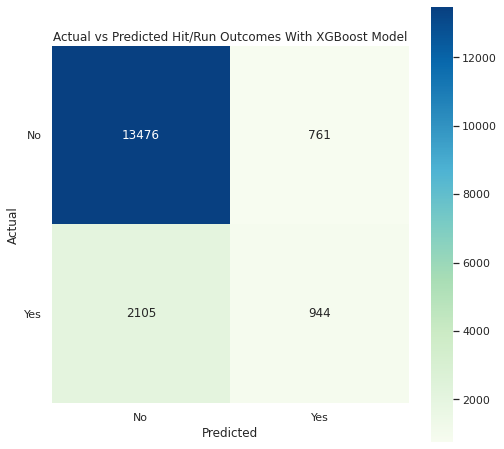

In [39]:
# create a confusion matrix to compare actual and predicted values
matrix = confusion_matrix(y_test, y_test_pred)
cm = pd.DataFrame(matrix)
cm.index = ['No', 'Yes']
cm.columns = ['No', 'Yes']

# plot confusion matrix
plt.figure(figsize=(8,8))
sns.set(font_scale=1)
ax = sns.heatmap(matrix, square=True, annot=True, fmt='d',cbar=True, cmap=plt.cm.GnBu)
class_labels = ['No', 'Yes']
ax.set_xticklabels(class_labels, rotation=0)
ax.set_yticklabels(class_labels, rotation=0)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Actual vs Predicted Hit/Run Outcomes With XGBoost Model')
plt.show()

In [40]:
# find the f1-score of the model after evaluating it with the test set
f1score = f1_score(y_true=y_test, y_pred=y_test_pred, average='micro')
print('The f1-score is: ',f1score)

The f1-score is:  0.8342010875853292


The f1-score of the xgboost model with the testing set is 0.8342, a relatively decent value. 

# Identifying the most important features

To test the hypothesis, the most significant features in the dataset need to be identified. If features pertaining to road infrastructure (e.g. light, road condition) generate the highest score, there will be sufficient evidence to prove that improving road conditions will impact likelihood of hit and run cases. 

In [41]:
# create a dataframe that stores each feature and its corresponding feature score
feature_importance = pd.DataFrame(columns=['Feature', 'Feature Score'])
feature_importance['Feature'] = X.columns
feature_importance['Feature Score'] = best_model.feature_importances_

# sort the feature_importance dataframe by feature score in descending order
feature_importance = feature_importance.sort_values(by='Feature Score', ascending=False)


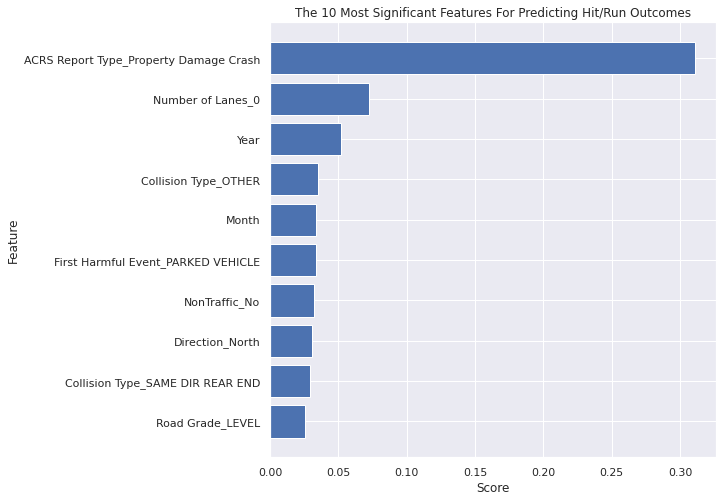

In [42]:
# plot the 10 most significant features 
plt.figure(figsize=(8,8))
plt.barh(feature_importance['Feature'][:10][::-1], feature_importance['Feature Score'][:10][::-1])
plt.ylabel('Feature')
plt.xlabel('Score')
plt.title('The 10 Most Significant Features For Predicting Hit/Run Outcomes')
plt.show()

The given results do not support the hypothesis. There is not enough evidence to confirm that road conditions play a significnat role in hit and run cases. The most important feature relevant to road conditions is the 'Road Grade' feature, which is the only the 10th most important feature.

According to the xgboost model, the most important feature for predicting hit and run incidents is the 'ACRS Report Type' feature. This makes sense, since drivers will have more incentive to leave if they believe that the damage caused from the crash is insignificant. 


*Note*: Although the 'Number of Lanes' feature is ranked 2nd and is related to the road infrastructure, it is not something that can be improved. Therefore, its high score does not support the hypothesis.


## Export Data For Visualization

For the final step, all relevant dataframes will be exported in the form of an .xlsx file, which will be used to present the descriptive statistics as well as the results of the research questions using Tableau.

In [43]:
with pd.ExcelWriter('results.xlsx') as writer:
  # exporting preprocessed dataset for descriptive statistics
  df_clean.to_excel(writer, sheet_name='Cleaned Dataset')
  # exporting the dataframe used for the confusion matrix
  cm.to_excel(writer, sheet_name='Confusion Matrix')
  # exporting the dataframe used for storing the feature importance
  feature_importance.to_excel(writer, sheet_name='Feature Importance Data')